# Проект "Обучение модели класификации комментариев для «Викишоп»"

**Описание проекта**
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

В нашем распоряжении набор данных с разметкой о токсичности правок.

**Цель проекта**
Обучить модель классифицировать комментарии на позитивные и негативные.<br>
Построить модель со значением метрики качества *F1* не меньше 0.75. 

**Задачи исследования**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.


**Исходные данные**
* Unnamed: 0: индекс комментария
* text: столбец с комментариями
* toxic: целевой признак, показатель токсичности

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Предварительный-просмотр-данных" data-toc-modified-id="Предварительный-просмотр-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Предварительный просмотр данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Балансирование-весов-классов" data-toc-modified-id="Балансирование-весов-классов-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Балансирование весов классов</a></span></li><li><span><a href="#Ресемплинг-с-уменшением-класса-0" data-toc-modified-id="Ресемплинг-с-уменшением-класса-0-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Ресемплинг с уменшением класса 0</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Классификатор-LogisticRegression" data-toc-modified-id="Классификатор-LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Классификатор LogisticRegression</a></span></li><li><span><a href="#Классификатор-DecisionTreeClassifier" data-toc-modified-id="Классификатор-DecisionTreeClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Классификатор DecisionTreeClassifier</a></span></li><li><span><a href="#Классификатор-CatBoostClassifier" data-toc-modified-id="Классификатор-CatBoostClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Классификатор CatBoostClassifier</a></span></li><li><span><a href="#Сравнение-моделей" data-toc-modified-id="Сравнение-моделей-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Сравнение моделей</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Итоговый вывод</a></span><ul class="toc-item"><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></li></ul></div>

## Подготовка

In [1]:
!pip install -U transformers datasets accelerate evaluate torch torchvision torchaudio --quiet --use-deprecated=legacy-resolver

In [2]:
!pip install huggingface_hub[hf_xet]

In [3]:
!pip install --upgrade transformers

In [4]:
# импорт библиотек
import os
import numpy as np
import pandas as pd
from datasets import Dataset, DatasetDict
import re
import torch
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_fscore_support
from sklearn.metrics import roc_curve, confusion_matrix, classification_report
from sklearn.utils import shuffle
from catboost import CatBoostClassifier
from tqdm.notebook import tqdm
import warnings

from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\persc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\persc\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\persc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\persc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\persc\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
# загрузка датасетов
pth1 = 'C:/Users/persc/Yandex.Disk/DataScience/Projects/Машинное обучение для текстов/toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'
pth2 = 'toxic_comments.csv'

if os.path.exists(pth1):
    toxic_comments = pd.read_csv(pth1)
elif os.path.exists(pth2):
    toxic_comments = pd.read_csv(pth2)
elif os.path.exists(pth3):
    toxic_comments = pd.read_csv(pth3)
else:
    print('Something is wrong')

### Предварительный просмотр данных

In [6]:
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


В датасете 159292 строк, пропусков нет.

In [7]:
toxic_comments.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [8]:
toxic_comments.describe()

,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


В шкале Unnamed: 0 максимальное количество не соответсвует количству строк, что значит, что порядок нумерации нарушен. Впрочем, для модели эти значения не нужны.

In [9]:
display(toxic_comments['toxic'].value_counts())

toxic
0    143106
1     16186
Name: count, dtype: int64

In [10]:
class_ratio = toxic_comments['toxic'].value_counts()[0] / toxic_comments['toxic'].value_counts()[1]
class_ratio

np.float64(8.841344371679229)

Классы несбалансированны - нетоксичных комментариев почти в 9 раз больше, чем токсичных. Необходимо будет применить способы балансировки.

### Предобработка данных

Проведем лемматизацию текстов

In [11]:
lemmatizer = WordNetLemmatizer()

In [12]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [13]:
def lemm_and_clear(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in tagged_tokens]
    lemmatized_text = ' '.join(lemmas)
    cleaned_text = re.sub(r'[^a-zA-Z\' ]', '', lemmatized_text)
    cleaned_text = cleaned_text.replace('\n', '')
    
    return cleaned_text

In [14]:
tqdm.pandas()
toxic_comments['lemm_text'] = toxic_comments['text'].progress_apply(lemm_and_clear)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [15]:
toxic_comments.head()

,Unnamed: 0,text,toxic,lemm_text
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,d'aww he match this background colour i 'm se...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man i 'm really not try to edit war it '...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more i ca n't make any real suggestion on imp...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember ...


In [16]:
toxic_comments = toxic_comments.drop(['text'], axis=1)
toxic_comments = toxic_comments.drop(['Unnamed: 0'], axis=1)

In [17]:
toxic_comments.duplicated().sum()

np.int64(627)

In [18]:
toxic_comments = toxic_comments.drop_duplicates()
toxic_comments.duplicated().sum()

np.int64(0)

Разобьем выборку по отношению 50/20/20.

In [19]:
target = toxic_comments['toxic']
features = toxic_comments[['lemm_text']]

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.5, 
                                                                              random_state=42)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5,
                                                                            random_state=42)

Вызовем функцию stopwords.words(), чтобы очистить тексты от стоп-слов. Нашим языком будет английский. Используем TfidfVectorizer, чтобы преобразовать тект в числовые векторы.

In [20]:
stop_words = stopwords.words('english')

Попробуем построить модель LogisticRegression.

In [21]:
# Создаем пайплайн
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', LogisticRegression(max_iter=1000))
])

In [22]:
# Кросс-валидация с пайплайном
train_f1 = cross_val_score(
    pipe, 
    features_train['lemm_text'],     
    target_train, 
    cv=3, 
    scoring='f1'
).mean()

print('F1 на CV:', train_f1)

F1 на CV: 0.6952711718299828


На тренировочной выборке модель показывает значение F1 = 0,69, что меньше требуемого значения. Требуется балансировка данных.

#### Балансирование весов классов

In [23]:
dict_classes = {
    0: 1,
    1: toxic_comments['toxic'].value_counts()[0] / toxic_comments['toxic'].value_counts()[1]
}

In [24]:
# Пайплайн: векторизация + логрег с балансом классов
pipe_balanced = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', LogisticRegression(class_weight=dict_classes, max_iter=1000))
])

In [25]:
train_f1_balanced = cross_val_score(
    pipe_balanced,
    features_train['lemm_text'],
    target_train,
    cv=3,
    scoring='f1'
).mean()

print('F1 на CV с балансированными классами:', train_f1_balanced)

F1 на CV с балансированными классами: 0.7390094264454922


In [26]:
# Пайплайн: векторизация + логрег с балансом классов 2 версия
pipe_balanced_auto = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

In [27]:
train_f1_balanced_auto = cross_val_score(
    pipe_balanced_auto,
    features_train['lemm_text'],
    target_train,
    cv=3,
    scoring='f1'
).mean()

print('F1 на CV с балансировкой весов классов:', train_f1_balanced)

F1 на CV с балансировкой весов классов: 0.7390094264454922


На балансированных классах модель показывает значение F1 уже ближе к требуемому - 0,73-0,74

F1 (без балансировки): 0.7110410094637224
ROC-AUC (без балансировки): 0.9655129221954609
F1 (ручная балансировка): 0.738801760126368
ROC-AUC (ручная балансировка): 0.9659169924963875
F1 (балансировка весов): 0.73150623885918
ROC-AUC (балансировка весов): 0.9658909184109311


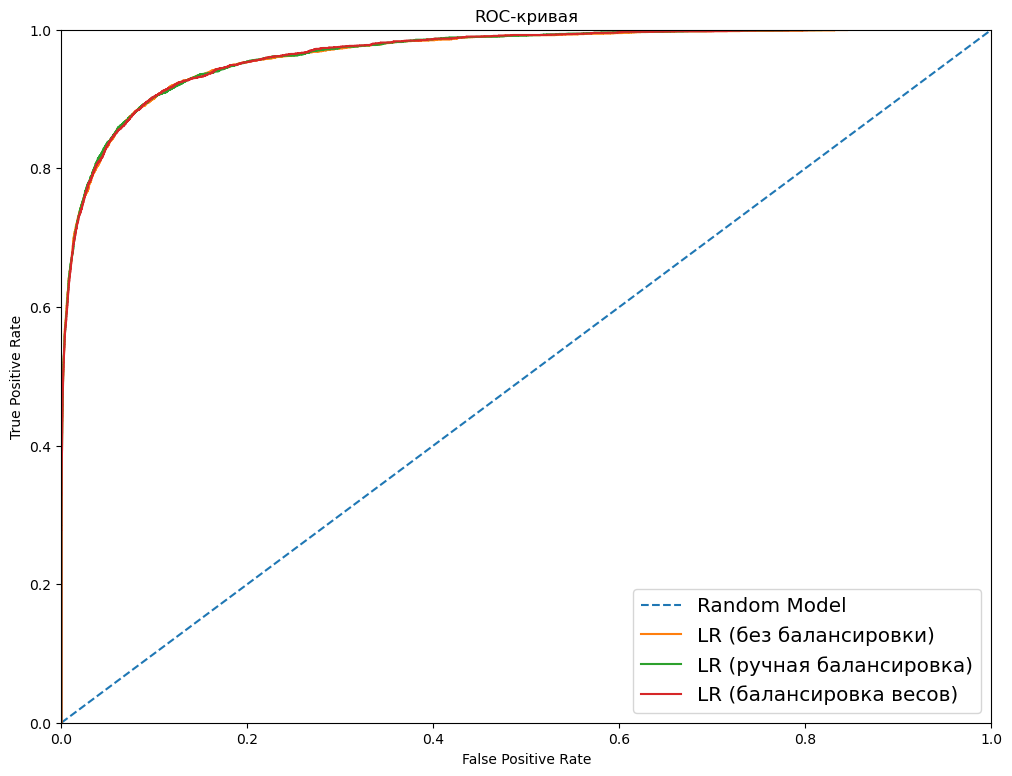

In [28]:
plt.figure(figsize=[12, 9])
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Model')

# Без балансировки
pipe.fit(features_train['lemm_text'], target_train)
probs = pipe.predict_proba(features_valid['lemm_text'])[:, 1]
fpr, tpr, _ = roc_curve(target_valid, probs)
valid_f1 = f1_score(target_valid, pipe.predict(features_valid['lemm_text']))
auc_roc = roc_auc_score(target_valid, probs)
plt.plot(fpr, tpr, label='LR (без балансировки)')
print("F1 (без балансировки):", valid_f1)
print("ROC-AUC (без балансировки):", auc_roc)

# Балансированные классы
pipe_balanced.fit(features_train['lemm_text'], target_train)
probs = pipe_balanced.predict_proba(features_valid['lemm_text'])[:, 1]
fpr, tpr, _ = roc_curve(target_valid, probs)
valid_f1_balanced = f1_score(target_valid, pipe_balanced.predict(features_valid['lemm_text']))
auc_roc_balanced = roc_auc_score(target_valid, probs)
plt.plot(fpr, tpr, label='LR (ручная балансировка)')
print("F1 (ручная балансировка):", valid_f1_balanced)
print("ROC-AUC (ручная балансировка):", auc_roc_balanced)

# Балансировка весов классов
pipe_balanced_auto.fit(features_train['lemm_text'], target_train)
probs = pipe_balanced_auto.predict_proba(features_valid['lemm_text'])[:, 1]
fpr, tpr, _ = roc_curve(target_valid, probs)
valid_f1_balanced_auto = f1_score(target_valid, pipe_balanced_auto.predict(features_valid['lemm_text']))
auc_roc_balanced_auto = roc_auc_score(target_valid, probs)
plt.plot(fpr, tpr, label='LR (балансировка весов)')
print("F1 (балансировка весов):", valid_f1_balanced_auto)
print("ROC-AUC (балансировка весов):", auc_roc_balanced_auto)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right', fontsize='x-large')
plt.title("ROC-кривая")
plt.show()

In [29]:
# Построим таблицу результатов балансировки
index = ['LR',
         'LR с ручной балансировкой весов',
         'LR с автоматической балансировкой весов'
        ]
data = {'F1 на CV':[train_f1,
                    train_f1_balanced,
                    train_f1_balanced_auto
                   ],
        'F1 на валидации':[valid_f1,
                           valid_f1_balanced,
                           valid_f1_balanced_auto
                          ],
        'AUC-ROC':[auc_roc,
                   auc_roc_balanced,
                   auc_roc_balanced_auto
                  ]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,F1 на CV,F1 на валидации,AUC-ROC
LR,0.695271,0.711041,0.965513
LR с ручной балансировкой весов,0.739009,0.738802,0.965917
LR с автоматической балансировкой весов,0.733622,0.731506,0.965891


### Вывод
В ходе предобработки мы леммитизировали тексты и разбили данные на выборки, исключив стоп-слова. По результатам теста для предобработки даных выберем LogisticRegression с ручной балансировкой весов, т.к. он показал наилучший результат по метрике F1 при валидации - 0,74.

## Обучение моделей

### Классификатор LogisticRegression

In [30]:
# Сетка гиперпараметров
param_grid = [
    # newton-cg
    {
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'tfidf__min_df': [1, 3, 5],
        'clf__solver': ['newton-cg'],
        'clf__penalty': ['l2'],
        'clf__C': [8, 10],
        'clf__class_weight': [None, 'balanced', dict_classes],
        'clf__random_state': [42]
    },
    # lbfgs
    {
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'tfidf__min_df': [1, 3, 5],
        'clf__solver': ['lbfgs'],
        'clf__penalty': ['l2'],
        'clf__C': [8, 10],
        'clf__class_weight': [None, 'balanced', dict_classes],
        'clf__random_state': [42]
    },
    # liblinear
    {
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'tfidf__min_df': [1, 3, 5],
        'clf__solver': ['liblinear'],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [8, 10],
        'clf__class_weight': [None, 'balanced', dict_classes],
        'clf__random_state': [42]
    }
]

print("\n")
print('# Tuning hyper-parameters for f1_score\n')

clf1 = GridSearchCV(pipe, param_grid, scoring='f1', cv=3, n_jobs=-1, error_score='raise')
clf1.fit(features_train['lemm_text'], target_train)


# Лучшие параметры
print("\n")
print("Best parameters set found on development set:\n")
LR_best_params = clf1.best_params_
print(LR_best_params, "\n")

# Результаты всех комбинаций
print("\n")
print("Grid scores on development set:\n")
means = clf1.cv_results_['mean_test_score']
stds = clf1.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf1.cv_results_['params']):
    print(f"{mean:.6f} (+/-{std:.6f}) for {params}")
print()

cv_f1_LR = np.nanmax(means)



# Tuning hyper-parameters for f1_score



Best parameters set found on development set:

{'clf__C': 8, 'clf__class_weight': None, 'clf__penalty': 'l1', 'clf__random_state': 42, 'clf__solver': 'liblinear', 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)} 



Grid scores on development set:

0.757007 (+/-0.010641) for {'clf__C': 8, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__random_state': 42, 'clf__solver': 'newton-cg', 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}
0.744218 (+/-0.005925) for {'clf__C': 8, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__random_state': 42, 'clf__solver': 'newton-cg', 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
0.759732 (+/-0.009721) for {'clf__C': 8, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__random_state': 42, 'clf__solver': 'newton-cg', 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)}
0.749793 (+/-0.007794) for {'clf__C': 8, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__random_state': 42, 'clf__solver

In [31]:
best_model = clf1.best_estimator_
target_predict = best_model.predict(features_valid['lemm_text'])
valid_f1_LR = f1_score(target_valid, target_predict)

print('F1 на CV:', clf1.best_score_)
print('F1 на валидации:', valid_f1_LR)

F1 на CV: 0.7704553564464462
F1 на валидации: 0.768066788416384


### Классификатор DecisionTreeClassifier

In [32]:
pipe_tree = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
    ('clf', DecisionTreeClassifier())
])

In [33]:
#classificator = DecisionTreeClassifier()
# Сетка гиперпараметров
param_grid = [{'clf__max_depth':list(range(50, 100, 2)),
                'clf__random_state':[42],
                'clf__class_weight':[dict_classes]
              }]


print('# Tuning hyper-parameters for f1_score')


clf2 = GridSearchCV(pipe_tree, param_grid, scoring='f1',cv=3, n_jobs=-1)
clf2.fit(features_train['lemm_text'], target_train)

# Лучшие параметры
print("Best parameters set found on development set:")
DTC_best_params = clf2.best_params_
print(DTC_best_params)

# Результаты всех комбинаций
print("Grid scores on development set:")
print()
means = clf2.cv_results_['mean_test_score']
stds = clf2.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf2.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_DTC = max(means)

# Tuning hyper-parameters for f1_score
Best parameters set found on development set:
{'clf__class_weight': {0: 1, 1: np.float64(8.839079746992434)}, 'clf__max_depth': 96, 'clf__random_state': 42}
Grid scores on development set:

0.606736 for {'clf__class_weight': {0: 1, 1: np.float64(8.839079746992434)}, 'clf__max_depth': 50, 'clf__random_state': 42}
0.611673 for {'clf__class_weight': {0: 1, 1: np.float64(8.839079746992434)}, 'clf__max_depth': 52, 'clf__random_state': 42}
0.598727 for {'clf__class_weight': {0: 1, 1: np.float64(8.839079746992434)}, 'clf__max_depth': 54, 'clf__random_state': 42}
0.599838 for {'clf__class_weight': {0: 1, 1: np.float64(8.839079746992434)}, 'clf__max_depth': 56, 'clf__random_state': 42}
0.607405 for {'clf__class_weight': {0: 1, 1: np.float64(8.839079746992434)}, 'clf__max_depth': 58, 'clf__random_state': 42}
0.609121 for {'clf__class_weight': {0: 1, 1: np.float64(8.839079746992434)}, 'clf__max_depth': 60, 'clf__random_state': 42}
0.616220 for {'clf__class_w

In [34]:
best_model = clf2.best_estimator_
target_predict = best_model.predict(features_valid['lemm_text'])
valid_f1_DTC = f1_score(target_valid, target_predict)

print('F1 на CV:', clf2.best_score_)
print('F1 на валидации:', valid_f1_DTC)

F1 на CV: 0.6366451831299703
F1 на валидации: 0.6247036510194405


### Классификатор CatBoostClassifier

In [35]:
pipe_catboost = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
    ('clf', CatBoostClassifier(verbose=False, iterations=250, random_state=42))
])

In [36]:
#classificator = CatBoostClassifier(verbose=False, iterations=250)
pipe_catboost.fit(features_train['lemm_text'], target_train)
target_predict = pipe_catboost.predict(features_valid['lemm_text'])
cv_f1_CBC = cross_val_score(pipe_catboost,
                                         features_train['lemm_text'], 
                                         target_train, 
                                         cv=3, 
                                         scoring='f1').mean()
valid_f1_CBC = f1_score(target_valid, target_predict)

print('F1 на CV', cv_f1_CBC)
print('F1 на валидации', valid_f1_CBC)

F1 на CV 0.7357448350042546
F1 на валидации 0.7347061476025853


### BERT

In [37]:
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", "cuda" if torch.cuda.is_available() else "cpu")

PyTorch: 2.8.0+cpu
CUDA available: False
Device: cpu


In [38]:
def _softmax_np(x, axis=1):
    x = x - np.max(x, axis=axis, keepdims=True)  # численно стабильный вариант
    e = np.exp(x)
    return e / np.sum(e, axis=axis, keepdims=True)

In [39]:
# Переводим каждую часть в DataFrame: текст + метка
train_df = pd.DataFrame({
    "text": features_train["lemm_text"].astype(str).values,
    "label": target_train.astype(int).values
})

valid_df = pd.DataFrame({
    "text": features_valid["lemm_text"].astype(str).values,
    "label": target_valid.astype(int).values
})

test_df = pd.DataFrame({
    "text": features_test["lemm_text"].astype(str).values,
    "label": target_test.astype(int).values
})

# Объединяем в единый DatasetDict для HuggingFace Trainer
ds = DatasetDict({
    "train": Dataset.from_pandas(train_df, preserve_index=False),
    "valid": Dataset.from_pandas(valid_df, preserve_index=False),
    "test":  Dataset.from_pandas(test_df,  preserve_index=False)
})

ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 79332
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 39666
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 39667
    })
})

In [40]:
BERT_model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(BERT_model)

id2label = {0: "NON_TOXIC", 1: "TOXIC"}
label2id = {"NON_TOXIC": 0, "TOXIC": 1}

# Токенизация
def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        padding=False,
        truncation=True,
        max_length=128
    )

ds_tok = ds.map(tokenize_fn, batched=True, remove_columns=["text"])
ds_tok = ds_tok.rename_column("label", "labels")
ds_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(
    BERT_model,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

Map:   0%|          | 0/79332 [00:00<?, ? examples/s]

Map:   0%|          | 0/39666 [00:00<?, ? examples/s]

Map:   0%|          | 0/39667 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(logits, (tuple, list)):
        logits = logits[0]

    probs = _softmax_np(logits, axis=1)[:, 1]   # вероятность класса 1
    preds = logits.argmax(axis=1)               # предсказанный класс

    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    _, _, f1w, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    try:
        auc = roc_auc_score(labels, probs)
    except ValueError:
        auc = float("nan")

    return {"accuracy": acc, "f1": f1, "f1_weighted": f1w, "roc_auc": auc}

In [42]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./bert-toxic-output",
    eval_strategy="epoch",    
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",     
    greater_is_better=True,
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=16,
    num_train_epochs=1,             
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    warmup_ratio=0.1,
    seed=42
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_tok["train"],
    eval_dataset=ds_tok["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [43]:
trainer.train()
best_metrics = trainer.evaluate(ds_tok["valid"])
best_metrics

Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Weighted,Roc Auc
1,0.048800,0.115512,0.967075,0.828789,0.966562,0.982841


{'eval_loss': 0.11551211774349213,
 'eval_accuracy': 0.9670750768920486,
 'eval_f1': 0.8287886733088621,
 'eval_f1_weighted': 0.9665620764547908,
 'eval_roc_auc': 0.9828406308842024,
 'eval_runtime': 1178.1734,
 'eval_samples_per_second': 33.667,
 'eval_steps_per_second': 2.105,
 'epoch': 1.0}

Test accuracy: 0.9660927219098999
Test F1: 0.826115061409179
Test ROC-AUC: 0.9825302175090211

Classification report:
               precision    recall  f1-score   support

   NON_TOXIC       0.98      0.99      0.98     35655
       TOXIC       0.86      0.80      0.83      4012

    accuracy                           0.97     39667
   macro avg       0.92      0.89      0.90     39667
weighted avg       0.97      0.97      0.97     39667



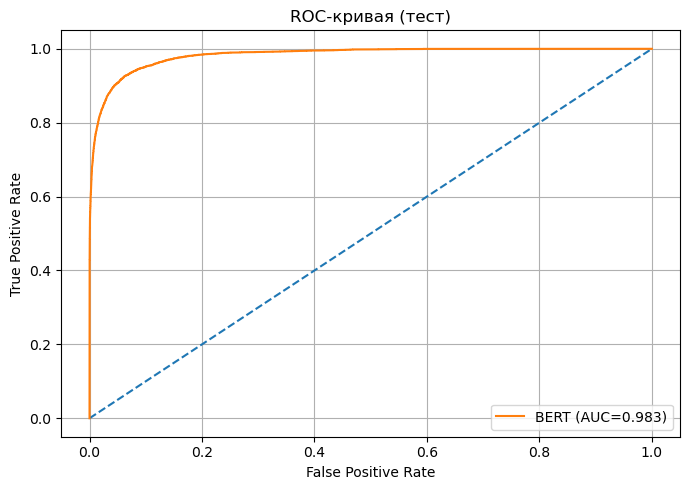

Confusion matrix:
 [[35127   528]
 [  817  3195]]


In [44]:
# Предсказания на тесте
pred_test = trainer.predict(ds_tok["test"])
logits = pred_test.predictions
labels = pred_test.label_ids
if isinstance(logits, (tuple, list)):
    logits = logiяts[0]

probs = _softmax_np(logits, axis=1)[:, 1]
preds = logits.argmax(axis=1)

# Метрики
test_acc = accuracy_score(labels, preds)
test_f1 = f1_score(labels, preds)
test_auc = roc_auc_score(labels, probs)
print("Test accuracy:", test_acc)
print("Test F1:", test_f1)
print("Test ROC-AUC:", test_auc)
print("\nClassification report:\n", classification_report(labels, preds, target_names=["NON_TOXIC","TOXIC"]))

# ROC-кривая
fpr, tpr, _ = roc_curve(labels, probs)
plt.figure(figsize=(7,5))
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, label=f"BERT (AUC={test_auc:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая (тест)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Матрица ошибок
cm = confusion_matrix(labels, preds)
print("Confusion matrix:\n", cm)

Использование BERT дает наиболее высокий результат метрики F1, тем не менее значительно проигрывает по времени исполнения. Дальнейшее усовершенствование модели (например, использование GPU) помогло бы сократить время обработки. 

### Сравнение моделей

In [45]:
index = ['LogisticRegression',
         'DecisionTreeClassifier',
         'CatBoostClassifier']
data = {'F1 на CV':[cv_f1_LR,
                    cv_f1_DTC,
                    cv_f1_CBC],
        'F1 на валидации':[valid_f1_LR,
                           valid_f1_DTC,
                           valid_f1_CBC]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение задачи'] = scores_data['F1 на валидации'] > 0.75
scores_data

,F1 на CV,F1 на валидации,Выполнение задачи
LogisticRegression,0.770455,0.768067,True
DecisionTreeClassifier,0.636645,0.624704,False
CatBoostClassifier,0.735745,0.734706,False


Модель LogisticRegression показывает лучшие значения F1 на валидационной выборке, и единственная удовлетворяет условиям поставленной задачи.

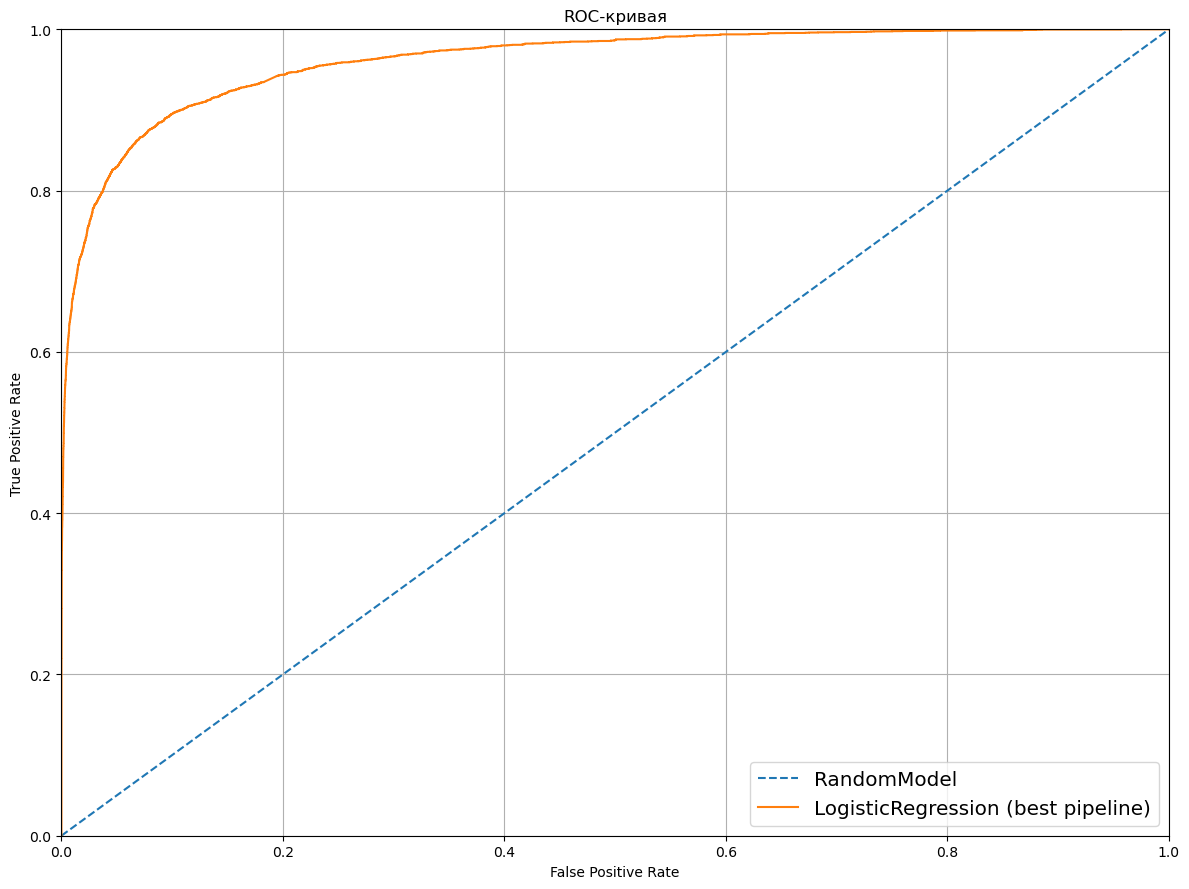

Метрики LogisticRegression (best pipeline)
ROC AUC: 0.9613806386198297
F1: 0.7650371128743281
Precision: 0.7861651762230405
Recall: 0.7450149551345963
Accuracy: 0.9537146746665994


In [51]:
best_lr = clf1.best_estimator_

# Предсказания на тесте
y_proba = best_lr.predict_proba(features_test['lemm_text'])[:, 1]
y_pred  = best_lr.predict(features_test['lemm_text'])

# ROC-кривая
fpr, tpr, _ = roc_curve(target_test, y_proba)

plt.figure(figsize=(12, 9))
plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')
plt.plot(fpr, tpr, label='LogisticRegression (best pipeline)')
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(loc='lower right', fontsize='x-large')
plt.title("ROC-кривая")
plt.grid(True)
plt.tight_layout()
plt.show()

# Метрики
print('Метрики LogisticRegression (best pipeline)')
print('ROC AUC:', roc_auc_score(target_test, y_proba))
print('F1:', f1_score(target_test, y_pred))
print('Precision:', precision_score(target_test, y_pred))
print('Recall:', recall_score(target_test, y_pred))
print('Accuracy:', accuracy_score(target_test, y_pred))

### Вывод
Наилучший результат в метрике F1 показала LogisticRegression - 0,77 на валидационной выборке.

## Итоговый вывод
* импортировали все необходимые библиотеки и функции, загрузили датасет
* провели лемматизацию текста, разделили данные на выборки, убрав стоп-слова
* подобрали способ балансирования весов классов
* обучили 3 модели (LogisticRegression, DecisionTreeClassifier, CatBoostClassifier)
* выбрали модель LogisticRegression, как показавшую наилучшую метрику F1 на валидационной выборке
* вывели характеристики выбранной модели: F1 = 0,765, ROC AUC = 0,961, Accuracy = 0,954

Для интернет-магазина "Викишоп" рекомендуется использовать модель LogisticRegression с предварительной балансировкой классов.